# Tornado Synthetic Dataset - 3D Steady
> [cgl datasets](https://cgl.ethz.ch/research/visualization/data.php)
> Steady means no time is involved

In [1]:
import numpy as np
import pyvista as pv
# np.set_printoptions(precision=3)

In [2]:
file = '..\\Data\\tornado3d.vti'
mesh = pv.read(file)
print(mesh)

UniformGrid (0x1c964dfab80)
  N Cells:	2048383
  N Points:	2097152
  X Bounds:	-1.000e+01, 1.000e+01
  Y Bounds:	-1.000e+01, 1.000e+01
  Z Bounds:	-1.000e+01, 1.000e+01
  Dimensions:	128, 128, 128
  Spacing:	1.575e-01, 1.575e-01, 1.575e-01
  N Arrays:	3



In [3]:
w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

vectors = np.empty((mesh.n_points, 3))
vectors[:,0] = u
vectors[:,1] = v
vectors[:,2] = w

print(f'mesh dimensions : {mesh.dimensions}')
print(f'128 * 128 * 128 = {128*128*128}')
print(f'u shape : {u.shape}\nv shape : {v.shape}\nw shape : {w.shape}')
print(f'vectors shape : {vectors.shape}')

mesh dimensions : (128, 128, 128)
128 * 128 * 128 = 2097152
u shape : (2097152,)
v shape : (2097152,)
w shape : (2097152,)
vectors shape : (2097152, 3)


In [4]:
# https://docs.pyvista.org/api/core/_autosummary/pyvista.RectilinearGrid.streamlines.html

mesh['vectors'] = vectors

boundary = mesh.decimate_boundary().extract_all_edges()

# Sphere Source
stream_base, seed_pts = mesh.streamlines(
    'vectors', 
    return_source=True,
    n_points=1,
    source_radius=0,
    source_center=(-4e-11,-4e-11,-4e-11)
)

# Line Source
# stream, src = mesh.streamlines(
#     'vectors', 
#     return_source=True,
#     n_points=100,
#     pointa=(-8, -8, 10),
#     pointb=(8, 8, 10),
#     integration_direction='both',
#     terminal_speed=-1,
#     step_unit='l',
#     initial_step_length=.01,
#     max_steps=6000,
#     min_step_length=.01
# )

sargs=dict(vertical=True, title_font_size=16)
p = pv.Plotter()
p.add_mesh(stream_base.tube(radius=0.02), lighting=False, scalar_bar_args=sargs)
# p.add_mesh(src)
p.add_mesh(boundary, color='grey', opacity=.25)
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [5]:
print(stream_base.point_data)

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : vectors
Active Vectors  : Normals
Active Texture  : None
Active Normals  : None
Contains arrays :
    u                       float32  (239,)
    v                       float32  (239,)
    w                       float32  (239,)
    vectors                 float64  (239, 3)             SCALARS
    IntegrationTime         float64  (239,)
    Vorticity               float64  (239, 3)
    Rotation                float64  (239,)
    AngularVelocity         float64  (239,)
    Normals                 float64  (239, 3)             VECTORS


In [6]:
print(seed_pts)

PolyData (0x1c974ed6460)
  N Cells:	1
  N Points:	1
  X Bounds:	-4.000e-11, -4.000e-11
  Y Bounds:	-4.000e-11, -4.000e-11
  Z Bounds:	-4.000e-11, -4.000e-11
  N Arrays:	0



# First Sample of s=2

In [22]:
s = 2


ws,vs,us = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

# us.shape = mesh.dimensions
# vs.shape = mesh.dimensions
# ws.shape = mesh.dimensions

# # Down Sample / Decimate
# us = us[::s, ::s, ::s] 
# vs = vs[::s, ::s, ::s]
# ws = ws[::s, ::s, ::s]

dims = us.shape

# # Flatten vectors
# us = us.flatten(order='F')
# vs = vs.flatten(order='F')
# ws = ws.flatten(order='F')

vectorss = np.empty((int(len(us)), 3))
vectorss[:,0] = us
vectorss[:,1] = vs
vectorss[:,2] = ws

m = np.linalg.norm(vectorss, axis=1).max() * .1
num = np.random.random_sample(vectorss.shape) * 2*m - m
print(m)
vectorss = num

print(dims)
mesh2 = pv.UniformGrid(
    # dims=dims,
    # spacing=tuple([x*s for x in list(mesh.spacing)]),
    dims=mesh.dimensions,
    spacing=mesh.spacing,
    origin=mesh.origin
)

print(f'mesh2 dimensions : {mesh2.dimensions}')
print(f'(64 * 64 * 64)  = {(64*64*64)}')
print(f'us shape : {us.shape}\nvs shape : {vs.shape}\nws shape : {ws.shape}')
print(f'vectorss shape : {vectorss.shape}')

print(vectorss.base)

0.6274744008575478
(2097152,)
mesh2 dimensions : (128, 128, 128)
(64 * 64 * 64)  = 262144
us shape : (2097152,)
vs shape : (2097152,)
ws shape : (2097152,)
vectorss shape : (2097152, 3)
None


In [25]:
mesh2['vectorss'] = vectorss

# print(seed_pts.points)

stream2 = mesh.streamlines_from_source(
    vectors=vectorss, 
    source=seed_pts
)

boundary2 = mesh2.decimate_boundary().extract_all_edges()

sargs=dict(vertical=True, title_font_size=16)
p = pv.Plotter()
p.add_mesh(stream2.tube(radius=0.02), lighting=False, scalar_bar_args=sargs)
p.add_mesh(boundary2, color='grey', opacity=.25)
p.show()

TypeError: streamlines_from_source() got multiple values for argument 'source'

# Generate Error between Streamlines

In [24]:
print(stream_base.n_cells)
print(stream2.n_cells)
a = 0
sargs=dict(vertical=True, title_font_size=16)
p = pv.Plotter()
p.add_mesh(stream2.cell_points(a), lighting=False, scalar_bar_args=sargs, color='red')
p.add_mesh(stream_base.cell_points(a), lighting=False, scalar_bar_args=sargs, color='blue')
p.add_mesh(boundary2, color='grey', opacity=.25)
p.show()

2
2


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [20]:
from scipy import interpolate

errors = []
for i in range(stream_base.n_cells):
    print(i)
    stream_1 = stream_base.cell_points(i).copy()
    stream_2 = stream2.cell_points(i).copy()
    # print(f'Stream 1 : {stream_1.shape}\nStream 2 : {stream_2.shape}\n')
    
    # Distance between each point in streamline
    dv_1 = stream_1[1:,:] - stream_1[:-1,:]
    dv_2 = stream_2[1:,:] - stream_2[:-1,:]
    
    # Length / Magnitude of each delta t
    dl_1 = np.sqrt(np.sum(dv_1**2, axis=1))
    dl_2 = np.sqrt(np.sum(dv_2**2, axis=1))
    
    t1 = np.r_[0, np.cumsum(dl_1)]
    t2 = np.r_[0, np.cumsum(dl_2)]
    # print(t1.shape)
   
    # Lengths of streamline
    length_1 = t1[-1]
    length_2 = t2[-1]
    # print(f'Stream 1 Length : {length_1}\nStream 2 Length : {length_2}\n')    

    x1 = interpolate.interp1d(t1, stream_1[:,0])
    y1 = interpolate.interp1d(t1, stream_1[:,1])
    z1 = interpolate.interp1d(t1, stream_1[:,2])
    p1 = lambda t : np.c_[x1(t), y1(t), z1(t)]
    
    x2 = interpolate.interp1d(t2, stream_2[:,0])
    y2 = interpolate.interp1d(t2, stream_2[:,1])
    z2 = interpolate.interp1d(t2, stream_2[:,2])
    p2 = lambda t : np.c_[x2(t), y2(t), z2(t)]
    

    t = np.linspace(0, min(length_1, length_2), 11)    
    ind_error = np.linalg.norm(p1(t) - p2(t), axis=1) # Same as magnitude
    tot_error = np.sum(ind_error)
    rms_error = np.sqrt(np.mean(ind_error**2))
    # print(ind_error.shape)

    errors.append(ind_error)

0
1


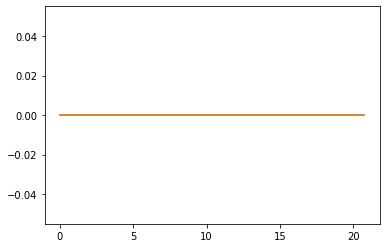

In [21]:
import matplotlib.pyplot as plt
for i in range(len(errors)):
    plt.plot(t, errors[i], label="error {i}")
# plt.legend()
plt.show()

# Histogram of error
# Compare different resolution errors and get an avg error and plot over different resolutions